# Predicting Monthly User Churn for Waze

This is an **advanced data analytics** project aimed at developing a machine learning model to predict **user churn**. Churn quantifies the number of users who have uninstalled the Waze app or stopped it. This project focuses on monthly user churn. An effective model will help prevent churn, improve user retention, and grow Waze’s business.

An effective model can also help identify specific factors that contribute to churn and answer questions such as: 
- Who are the users most likely to churn?
- Why do users churn? 
- When do users churn?

For example, if Waze can identify a segment of users who are at high risk of churning, Waze can proactively engage these users with special offers to try and retain them. Otherwise, Waze may lose these users without knowing why. 

Ultimately, the insights generated will help Waze leadership optimize the company’s retention strategy, enhance user experience, and make data-driven decisions about product development.

This is **Part 4** of the project.

## 4. Regression modeling

**The purpose** of this notebook is to demostrate the knowledge of regression modeling and analysis.

**The goal** is to build a binomial logistic regression model and evaluate the model's performance.

### 4a. Imports and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [2]:
# Load dataset into dataframe
df = pd.read_csv('waze_dataset.csv')

### 4b. Data cleaning and preprocessing

In [3]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


Remove the `ID` column since based on our analysis in Part 2, we don't need this information for further modeling or evaluation.

In [4]:
df = df.drop('ID', axis=1)

In [5]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Reminder that the dataset exhibits **class imbalance**, consisting of ≈82% retained users and ≈18% churned users.

In [6]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Are there any variables that could have outliers just by assessing at the quartile values, standard deviation, and max values?

> *Yes, based on our analysis in Part 2 and the assessment of quartiles, standard deviations, and maximum values from the table above, the following columns all seem to have outliers:*

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`


> *All of these columns have max. values that are multiple standard deviations above the 75th percentile. This could indicate outliers in these variables.*

#### Impute outliers

To address these outliers, we cap extreme values by imputing any observation greater than the 95th percentile with the corresponding 95th percentile value for that variable.

In [7]:
def outlier_imputer(column_name, percentile):
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)
    # Impute threshold for values > than threshold
    df.loc[df[column_name] > threshold, column_name] = threshold
    print('{:>25} | percentile: {} | threshold: {}'.format(column_name, percentile, threshold))

In [8]:
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    outlier_imputer(column, 0.95)

                 sessions | percentile: 0.95 | threshold: 243.0
                   drives | percentile: 0.95 | threshold: 201.0
           total_sessions | percentile: 0.95 | threshold: 454.3632037399997
   total_navigations_fav1 | percentile: 0.95 | threshold: 424.0
   total_navigations_fav2 | percentile: 0.95 | threshold: 124.0
         driven_km_drives | percentile: 0.95 | threshold: 8889.7942356
  duration_minutes_drives | percentile: 0.95 | threshold: 4668.899348999998


In [9]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,76.568705,64.058204,184.031320,1749.837789,114.415228,27.214281,3939.632764,1789.647426,15.537102,12.179879
std,67.297958,55.306924,118.600463,1008.513876,124.686795,36.735583,2216.041510,1222.705167,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,243.000000,201.000000,454.363204,3500.000000,424.000000,124.000000,8889.794236,4668.899349,31.000000,30.000000


#### Feature engineering

Create features that may be of interest and needed to address the problem scenario.

Many of these engineered features are derived directly from insights identified during the EDA conducted in previous parts of the project.

##### **`km_per_driving_day`**

Mean distance driven per driving day in the last month.

In [10]:
# Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.226746e+02
75%      7.370429e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [11]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       564.332421
std        963.973921
min          0.000000
25%        136.238895
50%        272.889272
75%        542.953671
max       8889.794236
Name: km_per_driving_day, dtype: float64

##### **`drives_per_driving_day`**

Mean number of drives in a driving day in the last month.

In [12]:
# Create `drives_per_driving_day` feature
df['drives_per_driving_day'] = df['drives'] / df['driving_days']

# Get descriptive stats
df['drives_per_driving_day'].describe()

count    1.499200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.800000e+00
50%      4.666667e+00
75%      1.173750e+01
max               inf
Name: drives_per_driving_day, dtype: float64

In [13]:
# Convert infinite values to zero
df.loc[df['drives_per_driving_day']==np.inf, 'drives_per_driving_day'] = 0

# Confirm that it worked
df['drives_per_driving_day'].describe()

count    14992.000000
mean         8.947009
std         17.911265
min          0.000000
25%          1.250000
50%          3.666667
75%          8.857143
max        201.000000
Name: drives_per_driving_day, dtype: float64

##### **`sessions_per_day`**

Mean number of sessions per day *since onboarding*.

In [14]:
# Create `sessions_per_day` feature
df['sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

# Get descriptive stats
df['sessions_per_day'].describe()

count    14999.000000
mean         0.329679
std          1.279856
min          0.000298
25%          0.051037
50%          0.100775
75%          0.209712
max         39.763874
Name: sessions_per_day, dtype: float64

##### **`km_per_drive`**

Mean number of kilometers per drive made in the last month.

In [15]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# Get descriptive stats
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.361484e+01
50%      7.424638e+01
75%      1.828004e+02
max               inf
Name: km_per_drive, dtype: float64

In [16]:
# Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       226.424311
std        578.656980
min          0.000000
25%         32.848406
50%         72.273118
75%        177.571053
max       8889.794236
Name: km_per_drive, dtype: float64

##### **`km_per_hour`**

Mean kilometers per hour driven in the last month.

In [17]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

# Get descriptive stats
df['km_per_hour'].describe()

count    14999.000000
mean       189.123436
std        322.431611
min         72.013095
25%         92.937040
50%        121.492474
75%        191.015037
max      21800.540069
Name: km_per_hour, dtype: float64

##### **`percent_of_drives_to_favorite`**

Percentage of total drives that were used to navigate to one of the users' favorite places.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [18]:
# Create `percent_of_drives_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.564610
std          8.103976
min          0.000000
25%          0.210144
50%          0.645181
75%          1.586659
max        671.949672
Name: percent_of_drives_to_favorite, dtype: float64

Some of the values observed in the descriptive statistics of the engineered columns above (particularly the maximum values) appear problematic and potentially invalid, even after outlier imputation. It would be worthwhile to seek clarification from Waze on how these features are collected to better understand why such unrealistic values occur. For now, we proceed with modeling.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   label                          14299 non-null  object 
 1   sessions                       14999 non-null  int64  
 2   drives                         14999 non-null  int64  
 3   total_sessions                 14999 non-null  float64
 4   n_days_after_onboarding        14999 non-null  int64  
 5   total_navigations_fav1         14999 non-null  int64  
 6   total_navigations_fav2         14999 non-null  int64  
 7   driven_km_drives               14999 non-null  float64
 8   duration_minutes_drives        14999 non-null  float64
 9   activity_days                  14999 non-null  int64  
 10  driving_days                   14999 non-null  int64  
 11  device                         14999 non-null  object 
 12  km_per_driving_day             14999 non-null 

In [20]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

# Drop rows with missing data in `drives_per_driving_day` column
df = df.dropna(subset=['drives_per_driving_day'])

#### Encode categorical variables

In [21]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


**Note**: We do not encode `device` here since it will be excluded from the model. This is because our statistical analysis in Part 3 showed no statistically significant difference in churn rates between iPhone and Android users, indicating that device type may not be a meaningful predictor.

#### Determine whether assumptions have been met

The following are the assumptions for logistic regression:

* Independent observations (This refers to how the data was collected.)
* No extreme outliers
* Little to no multicollinearity among X predictors
* Linear relationship between X and the **logit** of y

For the first assumption, we can assume that observations are independent for this project.

The second assumption has already been addressed.

The last assumption will be verified after modeling.

##### Collinearity

Check the correlation among predictor variables.

In [22]:
# Generate a correlation matrix
corr = df.corr(method='pearson', numeric_only=True)

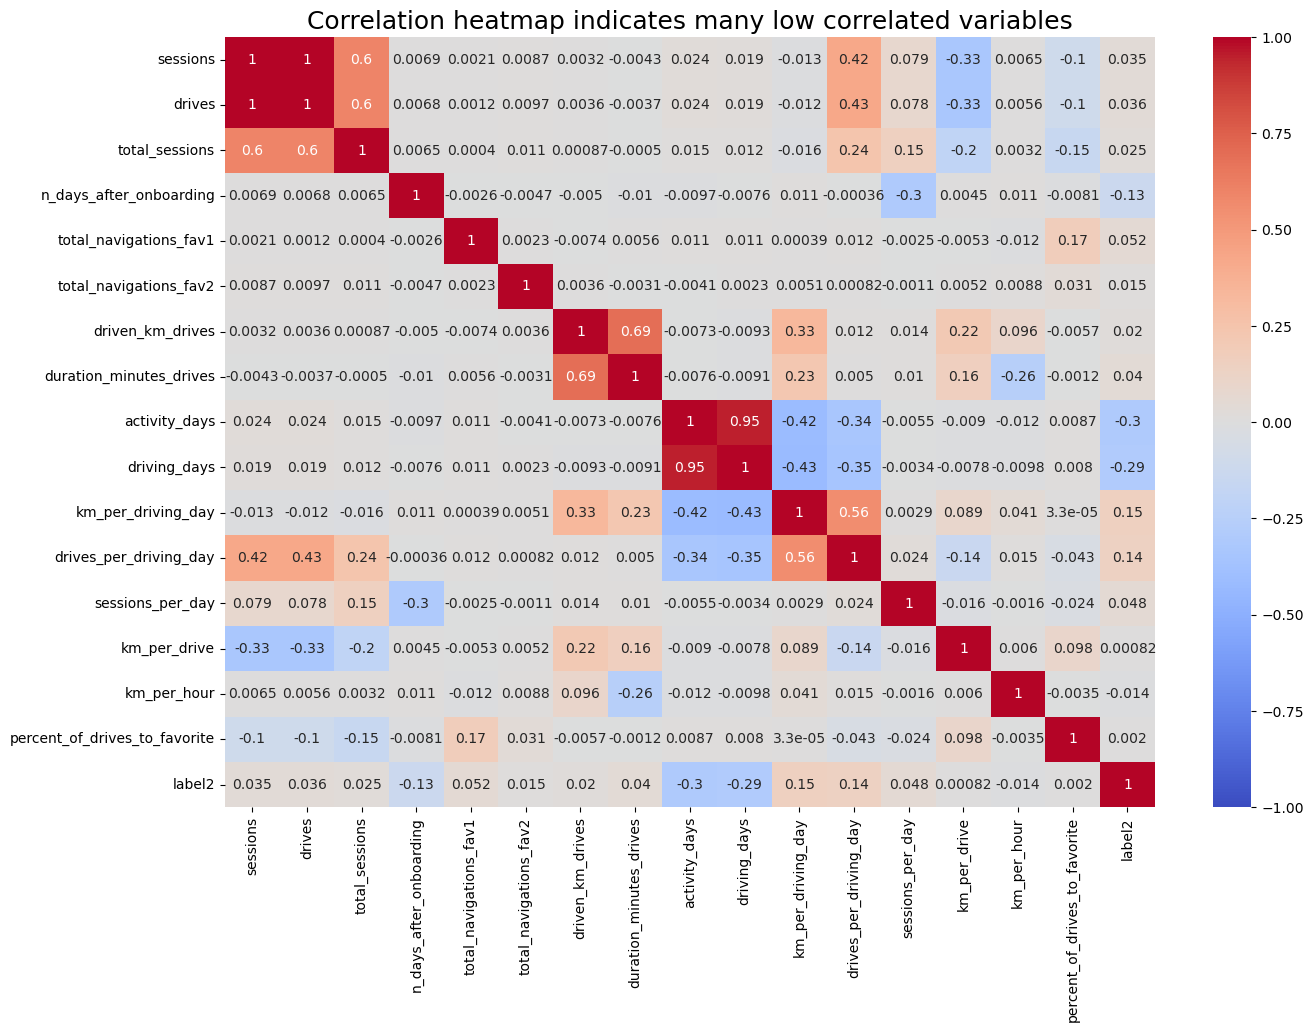

In [23]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show()

If there are predictor variables that have a Pearson correlation coefficient value greater than or equal to the **absolute value of 0.7**, these variables are strongly multicollinear. Therefore, only one of these variables should be used in our model.

Which variables are multicollinear with each other?

> * *`sessions` and `drives`: 1.0*
> * *`driving_days` and `activity_days`: 0.95*

Additionally, `driven_km_drives` and `duration_minutes_drives` (r = 0.69) show a moderately high correlation, just below the threshold.

To further validate these findings, we need to compute the Variance Inflation Factor (VIF).

In [24]:
# Choose predictors
X = df[['sessions', 'drives', 'driving_days', 'activity_days', 'driven_km_drives', 'duration_minutes_drives']]

# Add constant for intercept
X_const = sm.add_constant(X)

# Compute VIF for each column
vif = pd.DataFrame()
vif['Variable'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif

,Variable,VIF
0,const,8.637195
1,sessions,163.474382
2,drives,163.467069
3,driving_days,9.808278
4,activity_days,9.810150
5,driven_km_drives,1.911460
6,duration_minutes_drives,1.911504


Based on the VIF results above, we need to:

* Drop either `sessions` or `drives`, as they are perfectly collinear.
* Drop one of `driving_days` or `activity_days`, as they exhibit strong multicollinearity.

We will drop `sessions` and `driving_days` because they have weaker correlations with `label2` than `drives` and `activity_days`.

### 4c. Model building

To build our model, we first need to determine what variables we want to include in our model to predict our target: `label2`.

Drop the following variables and assign the results to `X`:

* `label` (this is the target)
* `label2` (this is the target)
* `device` (not meaningful predictor)
* `driving_days` (this had high multicollinearity)

In [25]:
# Isolate predictor variables
X = df.drop(columns=['label', 'label2', 'device', 'sessions', 'driving_days'])

# Isolate target variable
y = df['label2']

#### Split the data

We set the `stratify` parameter to `y` to ensure that the minority class appears in both train and test sets in the same proportion (82% `retained` vs. 18% `churned`) that it does in the overall dataset.

In [26]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale the data to help the model converge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# Fit a model
model = LogisticRegression(penalty=None, max_iter=10000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000, penalty=None)

Call the `.coef_` attribute on the model to get the coefficients of each variable.

The coefficients represent the change in the **log odds** of the target variable for **every one unit increase in X**.

In [28]:
pd.Series(model.coef_[0], index=X.columns).sort_values(key=np.abs, ascending=False)

activity_days                   -0.916725
n_days_after_onboarding         -0.388401
total_navigations_fav1           0.155361
duration_minutes_drives          0.153571
drives                           0.126182
driven_km_drives                -0.078507
km_per_drive                     0.055259
total_sessions                   0.036469
km_per_driving_day               0.035508
total_navigations_fav2           0.034742
sessions_per_day                 0.031809
percent_of_drives_to_favorite   -0.025792
km_per_hour                      0.020231
drives_per_driving_day          -0.012064
dtype: float64

Call the model's `intercept_` attribute to get the intercept of the model.

In [29]:
model.intercept_

array([-1.84901913])

#### Check final assumption

We need to verify the linear relationship between X and the estimated log odds (known as logits) by making a regplot.

In [30]:
# Get the predicted probabilities of the training set
training_probabilities = model.predict_proba(X_train_scaled)
training_probabilities

array([[0.94138187, 0.05861813],
       [0.63199148, 0.36800852],
       [0.88374168, 0.11625832],
       ...,
       [0.57414936, 0.42585064],
       [0.83813222, 0.16186778],
       [0.92534225, 0.07465775]])

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

In [31]:
# Convert `X_train` back to dataframe
logit_data = pd.DataFrame(X_train, columns=X.columns)

# Add the logit (log-odds) values
logit_data['logit'] = model.decision_function(X_train_scaled)

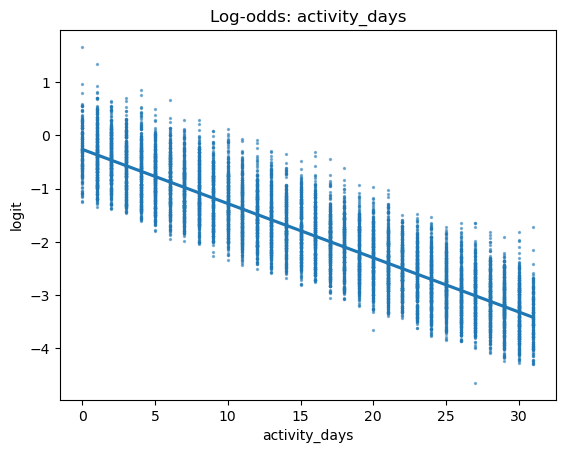

In [32]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

The plot above suggests that the assumption of a linear relationship between `activity_days` and the logit of the dependent variable is reasonably satisfied.

In an exhaustive analysis, this would be plotted for each continuous or discrete predictor variable. Here, we show only `activity_days`.

### 4d. Results and evaluation

If the logistic assumptions are met, the model results can be appropriately interpreted.

In [33]:
# Generate predictions on `X_test_scaled`
y_preds = model.predict(X_test_scaled)

#### Confusion matrix

In [34]:
cm = confusion_matrix(y_test, y_preds)

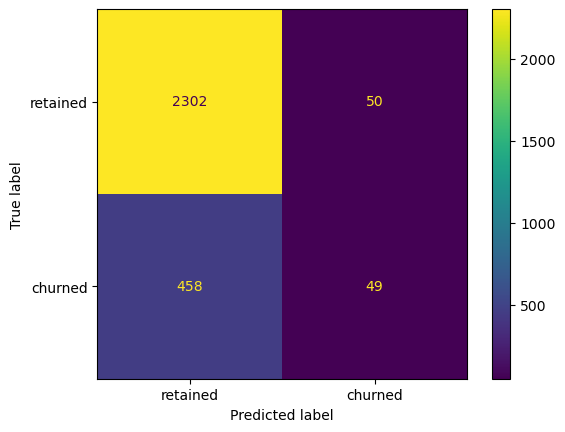

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned']
                              )
disp.plot()

In [36]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_preds)
accuracy

0.8223154949282966

In [37]:
# Calculate precision
precision = precision_score(y_test, y_preds)
precision

0.494949494949495

In [38]:
# Calculate recall
recall = recall_score(y_test, y_preds)
recall

0.09664694280078895

In [39]:
# Calculate F1-score
f1 = f1_score(y_test, y_preds)
f1

0.1617161716171617

In [40]:
# Calculate AUC
auc = roc_auc_score(y_test, y_preds)
auc

0.5376942196997141

In [41]:
# Create metrics table
metrics = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'AUC': [auc]
})
metrics

,Accuracy,Precision,Recall,F1-Score,AUC
0,0.822315,0.494949,0.096647,0.161716,0.537694


The model's accuracy is inflated by the majority class. Its very low recall (≈0.09) means it fails to identify most churned users, indicating the model is **not effective** for churn prediction.

### 4e. Logistic regression with regularization, hyperparameter tuning, and SMOTE

We will build a new logistic regression model with **Elastic Net regularization**, **hyperparameter tuning**, and **SMOTE** to ensure class balance. This approach helps reduce overfitting, stabilize coefficient estimates in the presence of multicollinearity, and may also perform implicit feature selection by shrinking unimportant predictors toward zero.

In [42]:
# Create binary `device2` column
df['device2'] = np.where(df['device']=='iPhone', 1, 0)

# Isolate predictor variables
# Keep all predictors for Elastic Net (including `device` as `device2`) except `sessions`, which had extreme multicollinearity with another predictor
X = df.drop(columns = ['label', 'label2', 'device', 'sessions'])

# Isolate target variable
y = df['label2']

In [43]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define the pipeline: scale features -> apply SMOTE -> fit logistic regression
# Using a Pipeline ensures scaling and SMOTE are applied inside each cross-validation (CV) fold 
# (fit only on that fold’s training split), preventing data leakage
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=42
    ))
])

# Define hyperparameter grid
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
}

# Grid search with 5-fold CV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='recall',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True
)

# Fit the model
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='recall')

In [44]:
# Print the results
print('Best parameters found: ', grid.best_params_)

Best parameters found:  {'clf__C': 0.01, 'clf__l1_ratio': 1}


In [45]:
# Get the best model
best_model = grid.best_estimator_

In [46]:
# Extract the trained LogisticRegression step from the pipeline
clf = best_model.named_steps['clf']  

# Retrieve coefficients, label them with feature names, and sort by absolute magnitude
coefs = (
    pd.Series(clf.coef_.ravel(), index=X.columns)
      .sort_values(key=np.abs, ascending=False)
)
coefs

activity_days                   -0.778324
n_days_after_onboarding         -0.387250
driving_days                    -0.148696
total_navigations_fav1           0.110292
duration_minutes_drives          0.077441
drives                           0.076227
km_per_hour                     -0.015024
sessions_per_day                 0.003095
total_sessions                   0.000000
total_navigations_fav2           0.000000
driven_km_drives                 0.000000
km_per_driving_day               0.000000
drives_per_driving_day           0.000000
km_per_drive                     0.000000
percent_of_drives_to_favorite    0.000000
device2                          0.000000
dtype: float64

In [47]:
# Retrieve intercept
intercept = clf.intercept_[0]
intercept

-0.3073418989123989

In [48]:
# Generate predictions on `X_test`
y_preds = best_model.predict(X_test)

#### Confusion matrix

In [49]:
cm = confusion_matrix(y_test, y_preds)

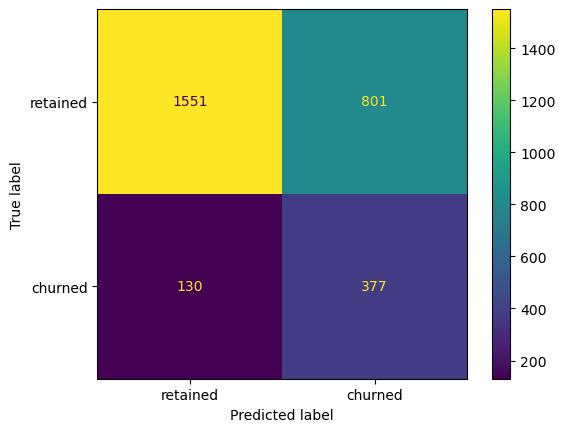

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned']
                             )
disp.plot()

In [51]:
# Calculate accuracy
new_accuracy = accuracy_score(y_test, y_preds)
new_accuracy

0.6743616649178035

In [52]:
# Calculate precision
new_precision = precision_score(y_test, y_preds)
new_precision

0.3200339558573854

In [53]:
# Calculate recall
new_recall = recall_score(y_test, y_preds)
new_recall

0.7435897435897436

In [54]:
# Calculate F1-score
new_f1 = f1_score(y_test, y_preds)
new_f1

0.44747774480712166

In [55]:
# Calculate AUC
new_auc = roc_auc_score(y_test, y_preds)
new_auc

0.7015142595499738

In [56]:
# Compare metrics of both models
metrics = pd.DataFrame({
    'Model': ['Original', 'New'],
    'Accuracy': [accuracy, new_accuracy],
    'Precision': [precision, new_precision],
    'Recall': [recall, new_recall],
    'F1-Score': [f1, new_f1],
    'AUC': [auc, new_auc]
})
metrics

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Original,0.822315,0.494949,0.096647,0.161716,0.537694
1,New,0.674362,0.320034,0.743590,0.447478,0.701514


The new model shows a big improvement over the original, with **significantly higher recall, F1, and AUC scores**. It now correctly identifies most churned users (recall ≈ 0.74) but has a tendency to misclassify retained users as churners (precision ≈ 0.32). Overall, it achieves an AUC of ≈0.70, reflecting fair discriminative ability in distinguishing churned users from retained ones.

### Conclusion

1. What variable most influenced the model's prediction? How? Was this surprising?

> *`activity_days` was by far the most important feature in the model. It had a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from our EDA in Part 2 to have a negative correlation with churn.*

2. Were there any variables that we expected to be stronger predictors than they were?

> *Yes. For example, in our EDA in Part 2, user churn rate increased as the values in `km_per_driving_day` increased. In the optimized model, it was not used as a predictor.*

3. Why might a variable we thought to be important not be important in the model?

> *In a multiple logistic regression model, features can interact with each other and these interactions can result in seemingly counterintuitive relationships. This is both a strength and a weakness of predictive models, as capturing these interactions typically makes a model more predictive while at the same time making the model more difficult to explain.*

4. Would we recommend that Waze use this model? Why or why not?

> *It depends. If the priority is predicting as many potential churners as possible—even at the cost of more false positives—the model is valuable, since its recall of ≈0.74 means it captures most churners.*

5. What additional features would we like to have to help improve the model?

> *It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.*

# END OF PART 4